# Wine Quality data set

In this notebook, I practise the the end-to-end data science project from chapter 2 on the Wine Quality data set from the UCI machine learning repository. This data set is suitable for regression or classification tasks. I will use regression to try and predict the quaity of a wine (a score from 0 to 10) based on physiochamical properties. This task is supervised using batch learning.


Citation:

P. Cortez, A. Cerdeira, F. Almeida, T. Matos and J. Reis. 
Modeling wine preferences by data mining from physicochemical properties. In Decision Support Systems, Elsevier, 47(4):547-553, 2009.

I have downloaded the data set already. There are two sets corresponding to red and white wines, which should be treated separately. The data is stored in csv format.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
red = pd.read_csv("datasets/wine_quality/winequality-red.csv", sep=";")
white = pd.read_csv("datasets/wine_quality/winequality-white.csv", sep=";")
red.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
fixed acidity           1599 non-null float64
volatile acidity        1599 non-null float64
citric acid             1599 non-null float64
residual sugar          1599 non-null float64
chlorides               1599 non-null float64
free sulfur dioxide     1599 non-null float64
total sulfur dioxide    1599 non-null float64
density                 1599 non-null float64
pH                      1599 non-null float64
sulphates               1599 non-null float64
alcohol                 1599 non-null float64
quality                 1599 non-null int64
dtypes: float64(11), int64(1)
memory usage: 150.0 KB


For the info, it shows that there are no missing values, so these will not have to be dealt with. Also, the quality data (the labels for each instance) are integer values. This allows us to apply some regularisation to the model, since the output values can only be integers from 0 to 10.

In [3]:
print('red\n', 
      red['quality'].value_counts(),
      '\nwhite\n', 
      white['quality'].value_counts())

red
 5    681
6    638
7    199
4     53
8     18
3     10
Name: quality, dtype: int64 
white
 6    2198
5    1457
7     880
8     175
4     163
3      20
9       5
Name: quality, dtype: int64


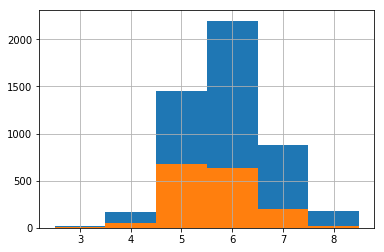

In [4]:
bins = np.arange(2.5, 9.5, 1)

white['quality'].hist(bins=bins)
red['quality'].hist(bins=bins)

We also see that the quality labels are bounded by 3-8 (red) and 3-9 (white) and are somewhat normally distributed, skewed left.

The features are all floating point numbers. There are no categorical features.

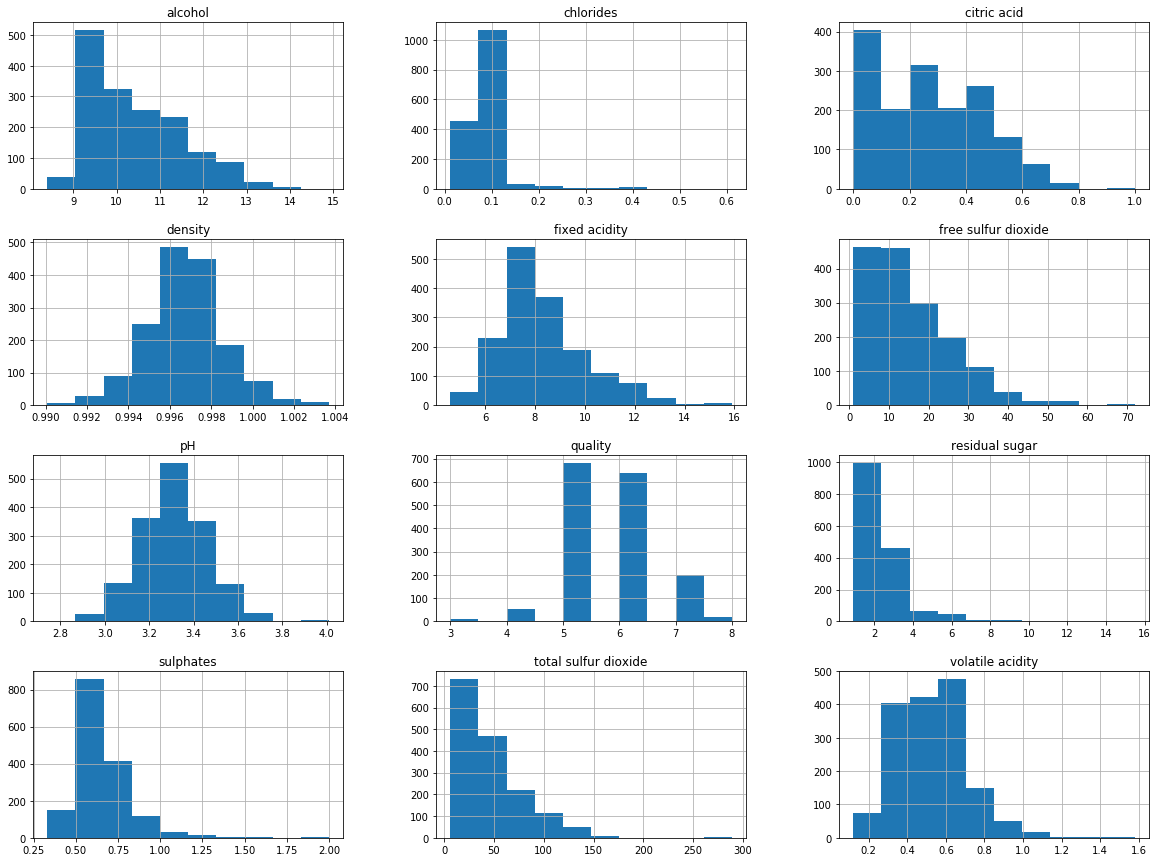

In [5]:
red.hist(figsize=(20, 15))
plt.show()

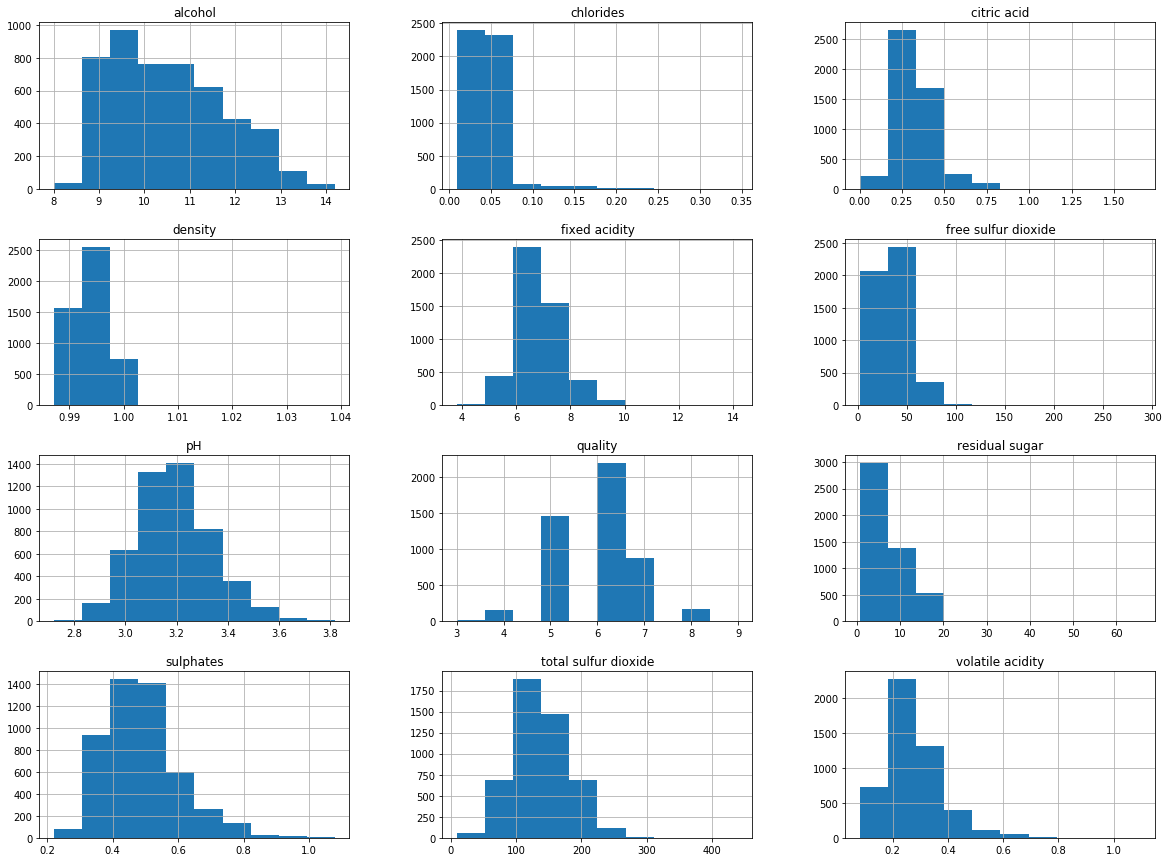

In [6]:
white.hist(figsize=(20, 15))
plt.show()

### Set aside the test sets

Before we look at the data, lets set aside the test sets. Since we haven't been told anything about each feature, there doesn't appear the need for stratified sampling. 

In [7]:
from sklearn.model_selection import train_test_split

red_train, red_test = train_test_split(red, test_size=0.2, random_state=42)
white_train, white_test = train_test_split(white, test_size=0.2, random_state=42)

### Analyse the training data

In [39]:
red = red_train.copy()
white = white_train.copy()

In [9]:
red_corr = red.corr()
white_corr = white.corr()

red_corr['quality'].sort_values(ascending=False)

quality                 1.000000
alcohol                 0.472676
sulphates               0.242596
citric acid             0.216115
fixed acidity           0.122488
residual sugar          0.005425
pH                     -0.045185
free sulfur dioxide    -0.055860
chlorides              -0.126541
density                -0.167091
total sulfur dioxide   -0.200067
volatile acidity       -0.378372
Name: quality, dtype: float64

In [10]:
white_corr['quality'].sort_values(ascending=False)

quality                 1.000000
alcohol                 0.431681
pH                      0.103161
sulphates               0.062008
free sulfur dioxide     0.028810
citric acid            -0.014022
residual sugar         -0.096854
fixed acidity          -0.117994
total sulfur dioxide   -0.162517
chlorides              -0.199168
volatile acidity       -0.204256
density                -0.300557
Name: quality, dtype: float64

Both data sets have a strong correlation between alcohol and the quality, however the red wine quality seems to depend most on the sulphates and acidity, while the white quality depends most on pH and density. This means each set will need a separate model.

Lets look at the red wine first:

## Red wine set

In [11]:
red_corr['quality'].sort_values(ascending=False)

quality                 1.000000
alcohol                 0.472676
sulphates               0.242596
citric acid             0.216115
fixed acidity           0.122488
residual sugar          0.005425
pH                     -0.045185
free sulfur dioxide    -0.055860
chlorides              -0.126541
density                -0.167091
total sulfur dioxide   -0.200067
volatile acidity       -0.378372
Name: quality, dtype: float64

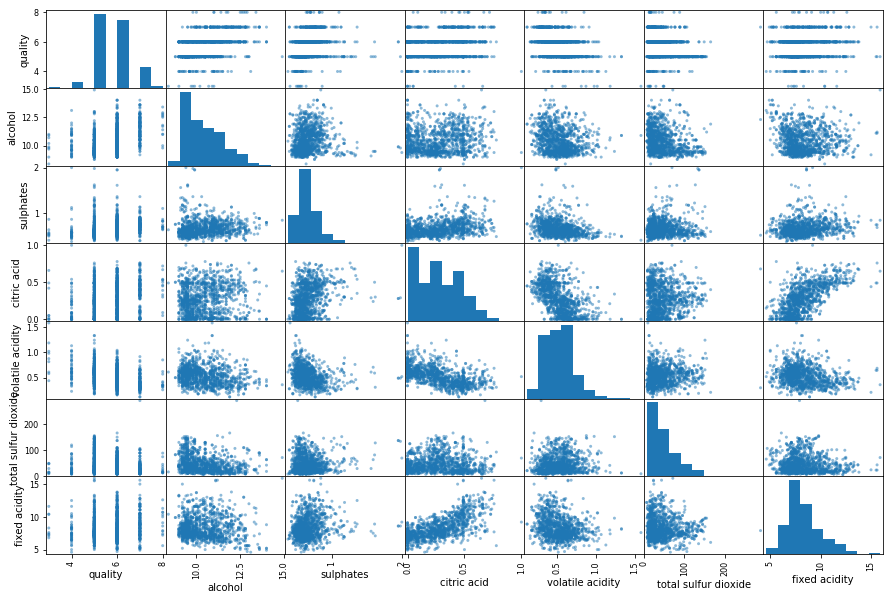

In [12]:
from pandas.plotting import scatter_matrix

attributes = ['quality', 'alcohol', 'sulphates', 
              'citric acid', 'volatile acidity', 'total sulfur dioxide', 'fixed acidity']

scatter_matrix(red[attributes], figsize=(15, 10))
plt.show()

There are no obvious trends between the attributes and the labels. However, there is a slight trend in the fixed acidity vs the citric acid (this makes some sense). This trend is quite rough though, so it is not worth merging the two attiributes.

Now we will use standardization on the attrubutes to bring the features to the same scale.

In [13]:
from sklearn.preprocessing import StandardScaler

red_X = red.drop('quality', axis=1)
red_y = red['quality']

red_scaler = StandardScaler()
red_X = red_scaler.fit_transform(red_X)

### Linear regression

In [14]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score

lin_reg_red = LinearRegression()

lin_reg_red.fit(red_X, red_y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

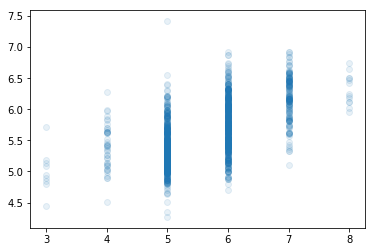

In [15]:
plt.scatter(red_y, lin_reg_red.predict(red_X), alpha=0.1)
plt.show()

The output from the linear regression shows when run on the entire training set shows is bounded by approximately 4-7.5 and while it does have a linear trend, the scatter about is very large.

The first thing to do is modify the LinearRegression to round the solutions to the nearest integer. This is nessesary to calculate the performance using cross_val_score.

In [16]:
class ModifiedLinearRegression(LinearRegression):

    def predict(self, y, *args, **kwargs):
        output = super().predict(y)
        return np.rint(output)


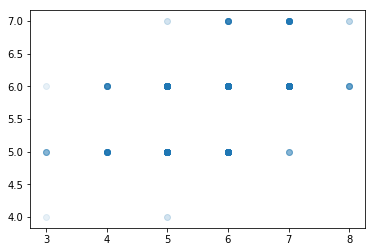

In [17]:
lin_reg_red_2 = ModifiedLinearRegression()

lin_reg_red_2.fit(red_X, red_y)

plt.scatter(red_y, lin_reg_red_2.predict(red_X), alpha=0.1)
plt.show()

In [18]:
from sklearn.metrics import mean_squared_error

mse = mean_squared_error(red_y, lin_reg_red_2.predict(red_X))
rmse = np.sqrt(mse)
print(rmse)

0.7156247919447547


Using the rmse is perhaps not the best metric to use here, since there are so few quality categories.

In [19]:
from sklearn.metrics import accuracy_score

print(accuracy_score(red_y, lin_reg_red_2.predict(red_X)))

0.5949960906958561


This is also a bad metric as it does not take into account for close classifications. For now we will stick with the mean_absolute_error:

In [20]:
from sklearn.metrics import mean_absolute_error

print(mean_absolute_error(red_y, lin_reg_red_2.predict(red_X)))

0.4401876465989054


In [21]:
scores = cross_val_score(lin_reg_red_2, red_X, red_y, cv=5, scoring="neg_mean_absolute_error")

print(np.mean(-scores))

0.44402573529411765


In any case, the linear regression is a bad model for this data set. Lets now try a descision tree:

### Descision tree regression

In [22]:
from sklearn.tree import DecisionTreeRegressor

tree_red = DecisionTreeRegressor()
scores = cross_val_score(tree_red, red_X, red_y, cv=5, scoring="neg_mean_absolute_error")

print(np.mean(-scores))

0.4690716911764706


The decision tree performs a little bit worse, so lets try a RandomForest:

In [23]:
from sklearn.ensemble import RandomForestRegressor

forest_red = RandomForestRegressor(n_estimators=100)
scores = cross_val_score(forest_red, red_X, red_y, cv=5, scoring="neg_mean_absolute_error")

print(np.mean(-scores))

0.4317298713235294


Now it is slightly better than the linear regression. Now we can quickly try a SVM (we will use a GridSearchCV for this).

In [24]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR

svr_red = SVR()

params = [
    {'kernel': ['poly'], 'degree': [2, 3, 4]},
    {'kernel': ['rbf'], 'C': [0.5, 0.8, 0.9, 1.0, 2.0, 5.0]},
]

grid_search_red = GridSearchCV(svr_red, param_grid=params, cv=5, scoring='neg_mean_absolute_error')

In [25]:
grid_search_red.fit(red_X, red_y)

GridSearchCV(cv=5, error_score='raise',
       estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'kernel': ['poly'], 'degree': [2, 3, 4]}, {'kernel': ['rbf'], 'C': [0.5, 0.8, 0.9, 1.0, 2.0, 5.0]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_absolute_error', verbose=0)

In [26]:
grid_search_red.best_params_

{'C': 2.0, 'kernel': 'rbf'}

In [27]:
cvres = grid_search_red.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(-mean_score, params)

0.644938957368682 {'degree': 2, 'kernel': 'poly'}
0.5591347409742621 {'degree': 3, 'kernel': 'poly'}
0.6600713735930029 {'degree': 4, 'kernel': 'poly'}
0.4731083016522543 {'C': 0.5, 'kernel': 'rbf'}
0.4672506508562144 {'C': 0.8, 'kernel': 'rbf'}
0.4663362433432004 {'C': 0.9, 'kernel': 'rbf'}
0.46554564433232953 {'C': 1.0, 'kernel': 'rbf'}
0.4648036099639154 {'C': 2.0, 'kernel': 'rbf'}
0.4678840183829391 {'C': 5.0, 'kernel': 'rbf'}


Lets try the random forest in the gridsearch also:

In [28]:
forest_red = RandomForestRegressor()

params = [
    {'bootstrap': [False], 'n_estimators': [3, 10, 20, 30], 'max_features': [4, 6, 8, 9, 10, 11]},
]

grid_search_red = GridSearchCV(forest_red, param_grid=params, cv=5, scoring='neg_mean_absolute_error')
grid_search_red.fit(red_X, red_y)

grid_search_red.best_params_

{'bootstrap': False, 'max_features': 6, 'n_estimators': 30}

In [29]:
cvres = grid_search_red.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(-mean_score, params)

0.4344540005212405 {'bootstrap': False, 'max_features': 4, 'n_estimators': 3}
0.4093041438623925 {'bootstrap': False, 'max_features': 4, 'n_estimators': 10}
0.40426114151681 {'bootstrap': False, 'max_features': 4, 'n_estimators': 20}
0.3993484493093563 {'bootstrap': False, 'max_features': 4, 'n_estimators': 30}
0.4469637737816002 {'bootstrap': False, 'max_features': 6, 'n_estimators': 3}
0.4136825645035183 {'bootstrap': False, 'max_features': 6, 'n_estimators': 10}
0.40574667709147777 {'bootstrap': False, 'max_features': 6, 'n_estimators': 20}
0.39854052645295807 {'bootstrap': False, 'max_features': 6, 'n_estimators': 30}
0.4469637737816002 {'bootstrap': False, 'max_features': 8, 'n_estimators': 3}
0.4254104769351056 {'bootstrap': False, 'max_features': 8, 'n_estimators': 10}
0.4150899139953087 {'bootstrap': False, 'max_features': 8, 'n_estimators': 20}
0.40933020589001823 {'bootstrap': False, 'max_features': 8, 'n_estimators': 30}
0.4451394318477977 {'bootstrap': False, 'max_features'

In [30]:
feature_importances = grid_search_red.best_estimator_.feature_importances_
sorted(zip(feature_importances, red.columns), reverse=True)


[(0.25052195946259986, 'alcohol'),
 (0.14988622576627236, 'sulphates'),
 (0.11537904440360326, 'volatile acidity'),
 (0.0706780740365255, 'total sulfur dioxide'),
 (0.06495983701048562, 'density'),
 (0.06448011842231262, 'pH'),
 (0.062111838950473855, 'chlorides'),
 (0.05777400836920853, 'residual sugar'),
 (0.05516013843447257, 'citric acid'),
 (0.05463405384894387, 'fixed acidity'),
 (0.05441470129510196, 'free sulfur dioxide')]

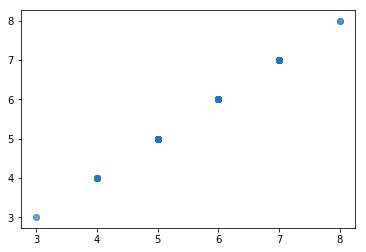

In [31]:
final_model = grid_search_red.best_estimator_

plt.scatter(red_y, final_model.predict(red_X), alpha=0.1)
plt.show()

When the final model is trained on the whole data set however, there is clearly overfitting going on:

In [32]:
print(mean_absolute_error(red_y, final_model.predict(red_X)))

0.0


## Evaluate on the test set

Since the random forest regressor is overfitting, we can expect poor performance on the test set, but we will have a look anyway:

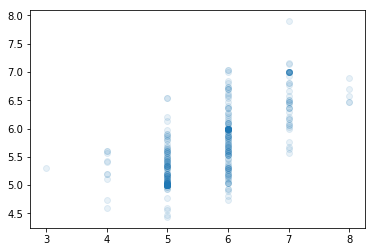

In [33]:
red_test_X = red_test.drop('quality', axis=1)
red_test_y = red_test['quality']

red_test_X = red_scaler.transform(red_test_X)

plt.scatter(red_test_y, final_model.predict(red_test_X), alpha=0.1)
plt.show()

In [34]:
print(mean_absolute_error(red_test_y, final_model.predict(red_test_X)))

0.41156249999999994


Even though it was overfitting, the model is not too bad at predicting on the test set. The average absolute error was 0.4, which means the majority of the predictions would be rounded correctly:

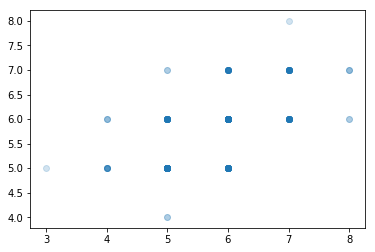

In [35]:
predictions = np.rint(final_model.predict(red_test_X))

plt.scatter(red_test_y, predictions, alpha=0.2)
plt.show()



Finally, I will perform the same analysis for the white wine:

## White wine

In [40]:
white_X = white.drop('quality', axis=1)
white_y = white['quality']

scaler_white = StandardScaler()
white_X = scaler_white.fit_transform(white_X)

Since we know the random forest will overfit, lets try the SVR instead:

In [43]:
svr_white = SVR()

params = [
    {'kernel': ['rbf'], 'C': [5.0, 6.0, 7.0, 10.0]},
]

grid_search_white = GridSearchCV(svr_white, param_grid=params, cv=5, scoring='neg_mean_absolute_error')
grid_search_white.fit(white_X, white_y)

GridSearchCV(cv=5, error_score='raise',
       estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'kernel': ['rbf'], 'C': [5.0, 6.0, 7.0, 10.0]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_absolute_error', verbose=0)

In [44]:
cvres = grid_search_white.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(-mean_score, params)

0.5164615026124806 {'C': 5.0, 'kernel': 'rbf'}
0.5163920460328756 {'C': 6.0, 'kernel': 'rbf'}
0.5165964174700146 {'C': 7.0, 'kernel': 'rbf'}
0.5178555276369337 {'C': 10.0, 'kernel': 'rbf'}


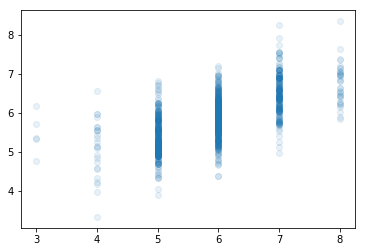

In [47]:
final_model_white = grid_search_white.best_estimator_

white_test_X = white_test.drop('quality', axis=1)
white_test_y = white_test['quality']

white_test_X = scaler_white.transform(white_test_X)

predictions = final_model_white.predict(white_test_X)

plt.scatter(white_test_y, predictions, alpha=0.1)
plt.show()

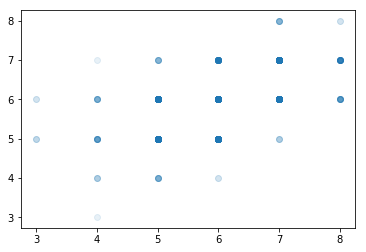

In [49]:
predictions = np.rint(predictions)

plt.scatter(white_test_y, predictions, alpha=0.1)
plt.show()

Again, the correct trend is observed, but there is still a large spread in the predictions. Also, the model does not predict well for the extrema points (3, 4 and 8)

## Conclusion:

This problem is an ordinal logistic regression problem:
The labels are discrete classes which have ordinal ranking (like movie ratings). There is currently no sklearn class which can do this, so one needs to be created. I am not going to spend more time on this now. I will return to it when I am doing classification.

The goal was to see if I could accurately guess the quality of the wine base on the chemical properties. In that point of view, this notebook was only partly successful. The models did manage to predict the quality in a general sense (the trend was approximately right) but there was still large scatter in the predictions. 

The range of quality values was quite small and largely centered around 5-7. The model does place most of the wines which are classified in the 5-7 range into the 5-7 range, however they are seemingly random. For the wines outside of this range, the models perfom poorly. THis is probably due to the large imbalance in the quality labels.

Since the grading of wines is a fairly subjective task, one would expect a weaker correlation to scientific data such as chemical properties. 
